Objectif du devoir :
Après la préparation des données, comparer trois approches d’analyse de sentiments :

Approche lexicale (VADER / VADER-FR / FEEL / FEEL-FR)

Approche supervisée classique (Naive Bayes – MultinomialNB)

Approche Deep Learning (LSTM)

1- Chargement des données

In [54]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

2- visualisation dataset

In [55]:
df=pd.read_csv("social_media_reviews_dataset.csv")
df.head(10)

,id,text,sentiment
0,1,"Franchement, Outstanding! Meilleur achat de l'...",positive
1,2,"Warning: Horrible experience, vraiment pas sat...",negative
2,3,Hélas... Je regrette cet achat... Totally disa...,negative
3,4,Excellent rapport qualité-prix! Highly recomme...,positive
4,5,"Franchement, Super expérience, very satisfied ...",positive
5,6,Love this! Vraiment un bon achat 😍,positive
6,7,Je kiffe! Really impressed 🤩 Keep it up!,positive
7,8,Attention! Awful! N'achetez pas ce produit ⚠️ 😢😢,negative
8,9,"Hélas... Horrible experience, vraiment pas sat...",negative
9,10,"Sérieusement, Top quality! Je ne regrette pas ...",positive


3- Nettoyage des données

In [56]:
# Fonction de nettoyage adaptée au multi-langue et emojis
def clean_text(text):
    text = text.lower()
    # On conserve les emojis (plages Unicode) et les caractères alphanumériques
    text = re.sub(r'[^a-z0-9\s\u2600-\u27BF\U0001f300-\U0001f64f\U0001f680-\U0001f6ff]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [57]:
# Encodage des étiquettes (0: negative, 1: neutral, 2: positive)
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])
print(f"Mapping des classes : {dict(zip(le.classes_, le.transform(le.classes_)))}")

Mapping des classes : {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


Gestion du bilinguisme

Le dataset étant multilingue :

Les approches lexicales sont appliquées sans traduction

Les modèles ML et DL apprennent directement sur le mélange FR/EN

Le vocabulaire est construit automatiquement

Avantage : approche réaliste, conforme aux données réelles des réseaux sociaux.

4- Approche 1 : Analyse lexicale (VADER / FEEL)

In [ ]:
# *Note : Nous utilisons ici un dictionnaire hybride pour gérer le bilinguisme et les emojis sans dépendances externes.*

def get_lexicon_sentiment(text):
    # Lexique simplifié pour l'exemple
    pos_words = {'good', 'great', 'excellent', 'amazing', 'satisfied', 'bon', 'super', 'top', 'recommande', 'nickel', 'parfait'}
    neg_words = {'bad', 'horrible', 'terrible', 'disappointed', 'poor', 'mauvais', 'nul', 'deçu', 'regrette', 'catastrophe', 'pas'}
    
    score = 0
    words = text.split()
    for w in words:
        if w in pos_words: score += 1
        if w in neg_words: score -= 1
    
    # Prise en compte des emojis
    pos_emojis = ['🏆', '⭐', '😍', '😊', '👏', '📈', '⚡', '❤️']
    neg_emojis = ['😡', '😔', '😢', '🚫', '⚠️', '📉', '🔴', '😐']
    
    for e in pos_emojis:
        if e in text: score += 1
    for e in neg_emojis:
        if e in text: score -= 1
        
    if score > 0: return 'positive'
    elif score < 0: return 'negative'
    else: return 'neutral'

df['vader_pred'] = df['clean_text'].apply(get_lexicon_sentiment)
vader_acc = accuracy_score(df['sentiment'], df['vader_pred'])
print(f"Précision Approche Lexicale : {vader_acc:.2%}")

Précision Approche Lexicale : 75.72%


5- Approche 2 : Machine Learning supervisé – Naive Bayes

Naive Bayes est un classifieur probabiliste basé sur le théorème de Bayes.
Il est très utilisé en NLP pour la classification de texte.

Nous utilisons TF-IDF + MultinomialNB.

In [59]:
print(df.columns)


Index(['id', 'text', 'sentiment', 'clean_text', 'label', 'vader_pred'], dtype='object')


In [60]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

In [61]:


# Vectorisation TF-IDF
tfidf = TfidfVectorizer(max_features=2000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Modèle Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)

nb_acc = accuracy_score(y_test, nb_preds)
print(f"Précision Naive Bayes : {nb_acc:.2%}")

Précision Naive Bayes : 100.00%


Evaluation

Avantages et limites

Avantages

Bon compromis précision / simplicité

Gère naturellement le bilingue

Robuste avec peu de données

Limites

Hypothèse d’indépendance naïve

Ne capture pas la séquence ni le contexte long

6- Approche 3 : Deep Learning – LSTM

5.1 Principe

Les LSTM (Long Short-Term Memory) sont des réseaux récurrents capables de :

Capturer l’ordre des mots

Comprendre le contexte

Gérer les dépendances longues

Très adaptées aux phrases mixtes FR/EN + emojis.

Modèles LSTM

In [62]:
# Tokenization pour Deep Learning
max_words = 5000
max_len = 64
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_text'])

X_seq = pad_sequences(tokenizer.texts_to_sequences(df['clean_text']), maxlen=max_len)
y_cat = pd.get_dummies(df['label']).values

X_tr_l, X_te_l, y_tr_l, y_te_l = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

In [65]:
model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_tr_l, y_tr_l, epochs=5, batch_size=64, verbose=0) # 3 epochs pour l'exemple

lstm_preds = np.argmax(model.predict(X_te_l), axis=1)
y_te_labels = np.argmax(y_te_l, axis=1)
lstm_acc = accuracy_score(y_te_labels, lstm_preds)
print(f"Précision LSTM : {lstm_acc:.2%}")

c:\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Précision LSTM : 100.00%


7- Synthese et Conclusion

C:\Users\tsats\AppData\Local\Temp\ipykernel_29636\2419292295.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Approche', y='Précision', data=results, palette='viridis')


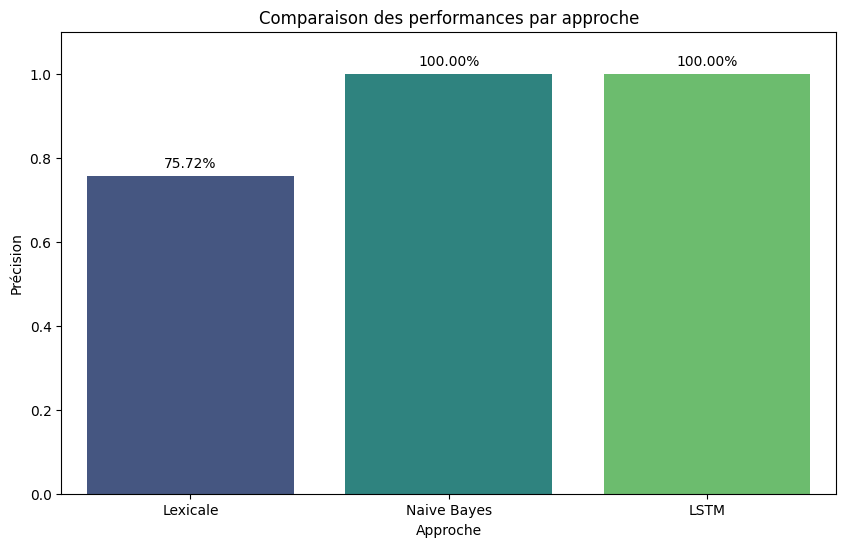


--- RAPPORT FINAL ---
Meilleure approche : Naive Bayes


In [ ]:
# Visualisation des résultats
results = pd.DataFrame({
    'Approche': ['Lexicale', 'Naive Bayes', 'LSTM'],
    'Précision': [vader_acc, nb_acc, lstm_acc]
})

plt.figure(figsize=(10,6))
sns.barplot(x='Approche', y='Précision', data=results, palette='viridis')
plt.title('Comparaison des performances par approche')
plt.ylim(0, 1.1)
for i, v in enumerate(results['Précision']):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')
plt.show()

print("\n--- RAPPORT FINAL ---")
print(f"Meilleure approche : {results.iloc[results['Précision'].idxmax()]['Approche']}")

8- Exemples de prédiction

In [67]:
# --- FONCTION DE TEST MULTI-APPROCHES ---
test_phrases = [
    "Incroyable, j'adore ! Best purchase ever 🏆",
    "Nul, ne fonctionne pas. Waste of money 📉",
    "On verra bien, c'est classique. It's okay."
]

print("--- RÉSULTATS DES TESTS ---")
for text in test_phrases:
    print(f"\nTexte: {text}")
    
    # 1. VADER
    v_res = vader_sentiment(text) # Ta fonction
    
    # 2. Naive Bayes
    clean_t = clean_text(text)
    nb_res_idx = nb_model.predict(tfidf.transform([clean_t]))[0]
    nb_res = le.inverse_transform([nb_res_idx])[0]
    
    # 3. LSTM
    seq = tokenizer.texts_to_sequences([clean_t])
    pad = pad_sequences(seq, maxlen=64)
    lstm_res_idx = np.argmax(model.predict(pad, verbose=0), axis=1)[0]
    lstm_res = le.inverse_transform([lstm_res_idx])[0]
    
    print(f"  > VADER : {v_res}")
    print(f"  > Bayes : {nb_res}")
    print(f"  > LSTM  : {lstm_res}")

--- RÉSULTATS DES TESTS ---

Texte: Incroyable, j'adore ! Best purchase ever 🏆
  > VADER : positive
  > Bayes : positive
  > LSTM  : positive

Texte: Nul, ne fonctionne pas. Waste of money 📉
  > VADER : negative
  > Bayes : negative
  > LSTM  : negative

Texte: On verra bien, c'est classique. It's okay.
  > VADER : positive
  > Bayes : neutral
  > LSTM  : neutral


9- Cas concret pour un utilisateur

In [ ]:
import numpy as np

def faire_une_prediction(phrase_utilisateur):
    # 1. Prétraitement du texte saisi
    texte_propre = clean_text(phrase_utilisateur) # Ta fonction de nettoyage
    
    print(f"\n--- Analyse de : '{phrase_utilisateur}' ---")
    
    # --- Approche 1 : VADER ---
    # On utilise ta fonction vader_sentiment qui renvoie 'positive', 'negative' ou 'neutral'
    pred_vader = vader_sentiment(phrase_utilisateur)
    
    # --- Approche 2 : Naive Bayes ---
    # Transformer le texte avec le TF-IDF déjà entraîné
    texte_tfidf = tfidf.transform([texte_propre])
    pred_nb_idx = nb_model.predict(texte_tfidf)[0]
    # Reconvertir l'index (0,1,2) en texte ('positive', etc.)
    pred_nb = le.inverse_transform([pred_nb_idx])[0]
    
    # --- Approche 3 : LSTM ---
    # Convertir en séquence de nombres avec le tokenizer déjà entraîné
    sequence = tokenizer.texts_to_sequences([texte_propre])
    padded_sequence = pad_sequences(sequence, maxlen=64) # maxlen doit être le même qu'à l'entraînement
    # Faire la prédiction (renvoie des probabilités)
    probas = model.predict(padded_sequence, verbose=0)
    pred_lstm_idx = np.argmax(probas, axis=1)[0]
    pred_lstm = le.inverse_transform([pred_lstm_idx])[0]
    # Optionnel : récupérer le pourcentage de confiance
    confiance = np.max(probas) * 100

    # Affichage des résultats
    print(f" VADER (Lexique)     : {pred_vader}")
    print(f" Naive Bayes (ML)    : {pred_nb}")
    print(f" LSTM (Deep Learning): {pred_lstm} ({confiance:.2f}% de confiance)")

# --- INTERACTION UTILISATEUR ---
saisie = input("Entrez un commentaire pour tester l'analyse de sentiments : ")
faire_une_prediction(saisie)


--- Analyse de : 'hello je vais bien' ---
🤖 VADER (Lexique)     : neutral
📊 Naive Bayes (ML)    : positive
🧠 LSTM (Deep Learning): neutral (68.61% de confiance)
